<a href="https://colab.research.google.com/github/atasoyfurkan/Autoencoder-for-Anomaly-Detection/blob/main/Bologna_Internship_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
sklearn.utils.check_random_state(SEED)
random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Fetch

In [ ]:
# Filter data not between time intervals
def filter_df_by_time(df, start_date, end_date):
  return df[df["timestamp"].between(pd.Timestamp(start_date), 
                                  pd.Timestamp(end_date))]

In [ ]:
# Read all data
base_path = "/content/drive/MyDrive/CMPE/Bologna-Internship/new_data/"
fname = 'r207n02.gzip'

df = pd.read_parquet(base_path+fname)
df = filter_df_by_time(df, '2020-06-01', '2021-04-01')
df = df.drop(['timestamp', "label"], axis=1)

# Autoencoder for Anomaly Detection

## Pre-processing

### Collect, Scale, Shuffle Data

In [ ]:
# Normalize the data to [0,1]
raw_data = df.to_numpy()
min_max_scaler = MinMaxScaler() # scale the matrix
scaled_data = min_max_scaler.fit_transform(raw_data)

In [ ]:
# Add an extension to solve Human Error to the Beginning of an anomaly sequence for calculating true-positive and false-positive
def extend_anomaly_sequences(data, hour=None):
  labels = data[:, -1]

  min = hour*60
  size = int(min/15)
  labels_lag = np.array(labels, copy=True)
  for i, label in enumerate(labels_lag):
    if label == 1 and i > 7 and labels_lag[i-1] != 1:
      labels_lag[i-size:i] = 1

  ids = np.array(range(0, len(labels_lag))).reshape(data.shape[0]) # add id column to dataframe
  labels_lag = labels_lag.reshape(data.shape[0], -1)

  data = np.append(data, labels_lag, axis=1)
  data = np.insert(data, 0, ids, axis=1)

  return data

In [ ]:
# # Windowed Shuffle
# def windowed_shuffle(data, day=7, validation_ratio=0.1, test_ratio=0.2): # window_size unit is day
#   window_size = int(day*96)
#   dataset = tf.data.Dataset.from_tensor_slices(data)
#   dataset = dataset.batch(window_size).shuffle(buffer_size=data.shape[0])
#   dataset = dataset.unbatch()

#   new_data = np.array([*dataset.as_numpy_iterator()])
#   labels = new_data[:, -2]

#   train_end = int(new_data.shape[0]*(1-test_ratio-((1-test_ratio)*validation_ratio)))
#   validation_end = int(new_data.shape[0]*(1-test_ratio))

#   train_data = new_data[:train_end]
#   validation_data = new_data[train_end:validation_end]
#   test_data = new_data[validation_end:]

#   labels_train = train_data[:, -2]
#   labels_validation = validation_data[:, -2]
#   labels_test = test_data[:, -2]


#   train_prop = np.sum(labels_train) / np.sum(labels) 
#   validation_prop = np.sum(labels_validation) / np.sum(labels) 
#   test_prop = np.sum(labels_test) / np.sum(labels) 

#   print("propotions:", train_prop, validation_prop, test_prop)

#   if validation_prop > validation_ratio*0.75 and test_prop > test_ratio*0.75:
#     return new_data
#   else:
#     return windowed_shuffle(data, day, validation_ratio, test_ratio)

In [ ]:
# Shuffle data in a way that all anomalies will be inserted to validation and test dataset
def shuffle_data(data, validation_ratio=0.1, test_ratio=0.2):
  new_data = np.array(data, copy=True)
  np.random.shuffle(new_data) 

  labels_lag = new_data[:, -1] # get labels with lag

  # Split data as normal and anomaly
  normal_data = new_data[labels_lag == 0] 
  anomaly_data = new_data[labels_lag == 1]

  # Collect the anomalies and split to test and validation
  anomaly_end_index = int(anomaly_data.shape[0] * 0.5) # half anomaly to test, half anomaly to validation  
  test_anomaly = anomaly_data[:anomaly_end_index] 
  validation_anomaly = anomaly_data[anomaly_end_index:]
  
  # Insert anomalies to test and validation dataset
  train_end_index = int(new_data.shape[0]*(1-test_ratio-((1-test_ratio)*validation_ratio)))
  validation_end_index = int(new_data.shape[0]*(1-test_ratio))

  print(train_end_index, validation_end_index)

  result_data = np.insert(normal_data, train_end_index, validation_anomaly, axis=0) # insert anomaly of validation
  result_data = np.insert(result_data, validation_end_index, test_anomaly, axis=0) # insert anomaly of test

  return result_data

In [ ]:
not_shuffled_data = extend_anomaly_sequences(scaled_data, hour=2)
data = shuffle_data(not_shuffled_data, validation_ratio=0.1, test_ratio=0.2)

In [ ]:
# Get labels of the data from columns
labels = data[:, -2]
labels_lag = data[:, -1]

### Splitting the data

In [ ]:
# Split the data to train, test, split
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)
data_train, data_validation = train_test_split(data_train, test_size=0.1, shuffle=False)

x_train = data_train[:, 1:-2]
x_test = data_test[:, 1:-2]
x_validation = data_validation[:, 1:-2]

labels_train = data_train[:, -2]
labels_test, labels_test_lag = data_test[:, -2], data_test[:, -1]
labels_validation, labels_validation_lag = data_validation[:, -2], data_validation[:, -1]

In [ ]:
# Split the data to normal, anomaly
x_train_normal = x_train[labels_train == 0]

x_test_normal = x_test[labels_test == 0]
x_validation_normal = x_validation[labels_validation == 0]

x_test_anomaly = x_test[labels_test == 1]
x_validation_anomaly = x_validation[labels_validation == 1]

In [ ]:
print(x_validation_normal.shape, x_test_normal.shape, x_train.shape)
print(x_validation_anomaly.shape, x_test_anomaly.shape)

(986, 460) (2593, 460) (9684, 460)
(91, 460) (98, 460)


## Visualization

Text(114.0, 0.5, 'Timestamps')

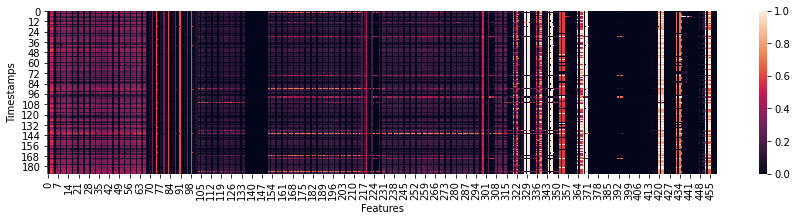

In [ ]:
fig, axes = plt.subplots(2, figsize=(15, 5))

sns.heatmap(x_validation_normal, ax=axes[0])
sns.heatmap(x_validation_anomaly, ax=axes[1])

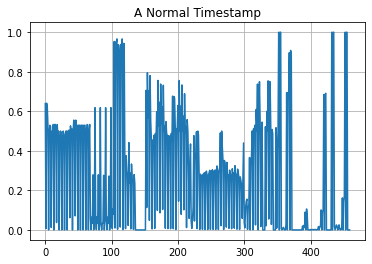

In [ ]:
# Visualize a timestamp for normal
index = 0
plt.grid()
plt.plot(x_validation_normal[index])
plt.title("A Normal Timestamp")
plt.show()

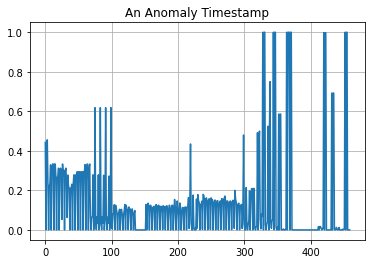

In [ ]:
# Visualize a timestamp for anomaly
index = 0
plt.grid()
plt.plot(x_validation_anomaly[index])
plt.title("An Anomaly Timestamp")
plt.show()

## Implementation and Training

In [ ]:
# Functional API implementation of Autoencoder
input_shape = x_train_normal.shape[1]
hidden_dims = []

latent_dim = 40
n = 3

decrease_rate = round(np.power((input_shape/latent_dim), 1/(n+1)), 3)

for i in range(0, n):
  if i == 0:
    hidden_dims.append(int(input_shape / decrease_rate))
  else:
    hidden_dims.append(int(hidden_dims[i-1] / decrease_rate))

latent_dim = int(np.ceil(hidden_dims[-1] / decrease_rate))

# Encoder
encoder_input = tf.keras.Input(shape=input_shape, name="original_data")
x = tf.keras.layers.Dense(hidden_dims[0], activation="relu")(encoder_input)
for i in range(1,n):
  x = tf.keras.layers.Dense(hidden_dims[i], activation="relu")(x)
encoder_output = tf.keras.layers.Dense(latent_dim, activation="relu")(x)

encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

# Decoder
decoder_input = tf.keras.Input(shape=latent_dim, name="encoded_data")
x = tf.keras.layers.Dense(hidden_dims[-1], activation="relu")(decoder_input)
for i in range(2, n+1):
  x = tf.keras.layers.Dense(hidden_dims[-i], activation="relu")(x)
decoder_output = tf.keras.layers.Dense(input_shape, activation="sigmoid")(x)

decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

# Autoencoder
autoencoder_input = tf.keras.Input(shape=input_shape, name="data")
encoded_data = encoder(autoencoder_input)
decoded_data = decoder(encoded_data)
autoencoder = tf.keras.Model(autoencoder_input, decoded_data, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_data (InputLayer)   [(None, 460)]             0         
_________________________________________________________________
dense (Dense)                (None, 249)               114789    
_________________________________________________________________
dense_1 (Dense)              (None, 135)               33750     
_________________________________________________________________
dense_2 (Dense)              (None, 73)                9928      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2960      
Total params: 161,427
Trainable params: 161,427
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output 

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

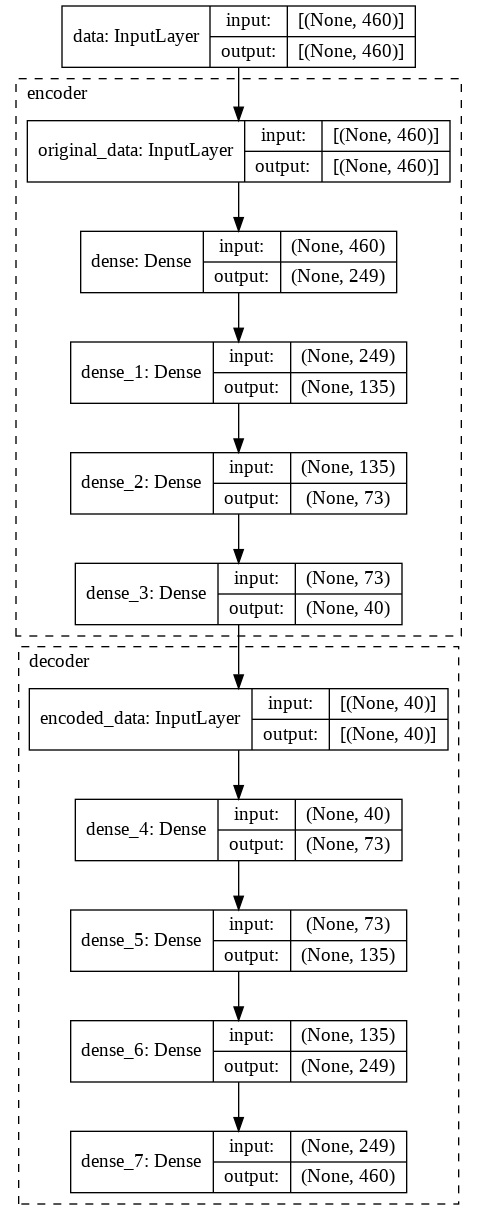

In [ ]:
tf.keras.utils.plot_model(autoencoder, "autoencoder.png", show_shapes=True, expand_nested=True)

In [ ]:
history = autoencoder.fit(x_train_normal, x_train_normal, 
          epochs=100, 
          batch_size=512,
          validation_data=(x_validation_normal, x_validation_normal),
          shuffle=False)

## Evaluation

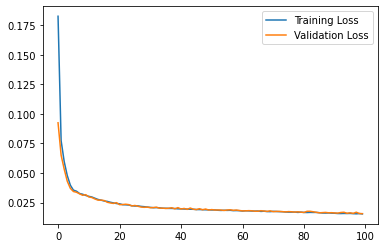

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

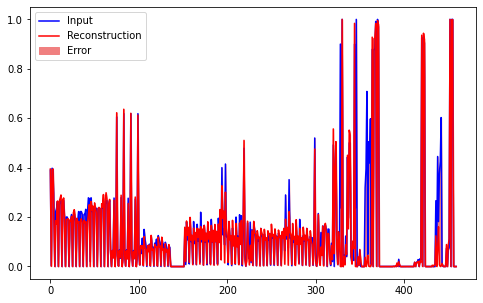

In [ ]:
index = 20

encoded_data = encoder(x_validation_normal).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.figure(figsize=(8, 5))
plt.plot(x_validation_normal[index], 'b')
plt.plot(decoded_data[index], 'r')
plt.fill_between(np.arange(input_shape), decoded_data[index], x_validation_normal[index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
def plot_loss(model, normal, anomalous, loss_func, bins=50):
  reconstructions = model.predict(normal)
  loss_normal = loss_func(reconstructions, normal)

  reconstructions = model.predict(anomalous)
  loss_anomalous = loss_func(reconstructions, anomalous)

  plt.hist(loss_normal, bins=bins, alpha=.6, color="green")
  plt.hist(loss_anomalous, bins=bins, alpha=.6, color="red")  
  plt.xlabel("Loss")
  plt.ylabel("No of examples")
  plt.show()

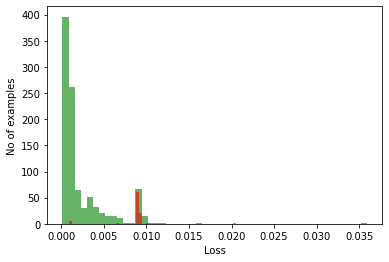

In [ ]:
custom_loss_func = tf.keras.losses.mse

plot_loss(autoencoder, x_validation_normal, x_validation_anomaly, custom_loss_func, bins=50)

In [ ]:
def evaluation_metrics(pred, labels, labels_lag):
  tn, _, fn, _ = confusion_matrix(labels, pred).ravel()
  _, fp, _, tp = confusion_matrix(labels_lag, pred).ravel()

  accuracy = (tp+tn)/(tp+tn+fp+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f0dot5 = (1.25 * precision * recall) / (0.25 * precision + recall)
  f1 = (2 * precision * recall) / (precision + recall)
  f2 = (5 * precision * recall) / (4 * precision + recall)

  return accuracy, precision, recall, np.array([[tn, fp], [fn, tp]]), f0dot5, f1 ,f2

In [ ]:
def find_threshold_for_losses(losses, labels, labels_lag):
  max_threshold = -1
  max_score = -1
  step = np.mean(losses) / 100
  float_range_list = list(np.arange(0, np.max(losses), step))

  for threshold in float_range_list:
    pred = losses > threshold
    accuracy, precision, recall, *_, f2 = evaluation_metrics(pred, labels==1, labels_lag==1)

    tmp_score = f2
    if tmp_score > max_score:
      max_threshold = threshold
      max_score = tmp_score
  
  return max_threshold

In [ ]:
reconstructions = autoencoder.predict(x_validation)
loss_by_timestamp = custom_loss_func(reconstructions, x_validation)

threshold = find_threshold_for_losses(loss_by_timestamp, labels_validation, labels_validation_lag)
print("threshold:" ,threshold)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


threshold: 0.0088147778991443


In [ ]:
def predict(model, data, threshold, loss_func):
  reconstructions = model(data)
  loss = loss_func(reconstructions, data)
  return tf.math.greater(loss, threshold)

def print_stats(predictions, labels, labels_lag):
  accuracy, precision, recall, conf_matrix, f0dot5, f1 ,f2 = evaluation_metrics(predictions, labels==1, labels_lag==1)

  print("Accuracy = {}".format(accuracy))
  print("Precision = {}".format(precision))
  print("Recall = {}".format(recall))
  print("F0.5 Score = {}".format(f0dot5))
  print("F1 Score = {}".format(f1))
  print("F2 Score = {}".format(f2))

  print("Confusion Matrix\n{}".format(conf_matrix))

  return accuracy, precision, recall, conf_matrix

In [ ]:
def plot_timeline(predictions, labels, labels_lag):
  ids = np.array(data[:, 0], dtype="int64") # first column is the id of the timestamp
  ids_train = np.array(data_train[:, 0], dtype="int64")
  ids_test = np.array(data_test[:, 0], dtype="int64")
  ids_validation = np.array(data_validation[:, 0], dtype="int64")  

  color = np.zeros(shape=ids.shape).astype(str)
  np.put(color, ids_validation, "blue")
  np.put(color, ids_test, "red")
  np.put(color, ids_train, "green")
  time = range(0,len(labels))

  plt.figure(figsize=(100,3))
  plt.scatter(time, labels*2, c=color, s=1)
  plt.scatter(time, labels_lag*1.5, c="orange", s=1)
  plt.scatter(time, predictions, c='g', s=1)

In [ ]:
preds = predict(autoencoder, x_test, threshold, custom_loss_func)
test_accuracy, test_precision, test_recall, test_conf_matrix = print_stats(preds, labels_test, labels_test_lag)

Accuracy = 0.9279078409513192
Precision = 0.35664335664335667
Recall = 0.9107142857142857
F0.5 Score = 0.40605095541401276
F1 Score = 0.5125628140703518
F2 Score = 0.6948228882833788
Confusion Matrix
[[2395  184]
 [  10  102]]


Accuracy = 0.9356229556943205
Precision = 0.19754253308128544
Recall = 0.9247787610619469
F0.5 Score = 0.2344100493494841
F1 Score = 0.32554517133956384
F2 Score = 0.5326197757390418
Confusion Matrix
[[12377   849]
 [   17   209]]


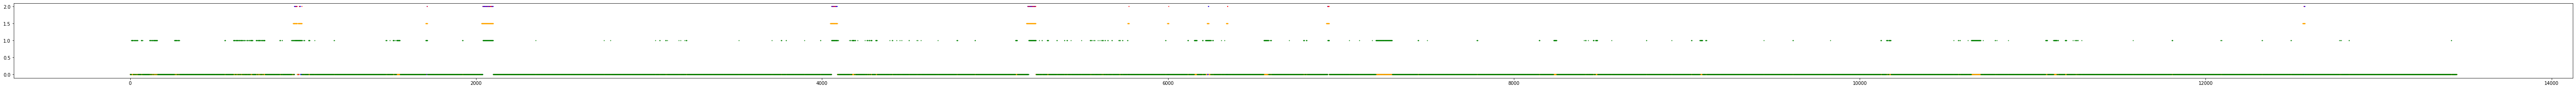

In [ ]:
not_shuffled_label = not_shuffled_data[:, -2]
not_shuffled_label_lag = not_shuffled_data[:, -1]
not_shuffled_timestamps = not_shuffled_data[:, 1:-2]

is_anomaly = predict(autoencoder, not_shuffled_timestamps, threshold, custom_loss_func)
all_accuracy, all_precision, all_recall, all_conf_matrix = print_stats(is_anomaly, not_shuffled_label, not_shuffled_label_lag)

plot_timeline(is_anomaly, not_shuffled_label, not_shuffled_label_lag)

## Post-processing (Filter Columns with Losses of Validation Dataset)

### Implementation

In [ ]:
LOSS_FILTER_COUNT = 22

In [ ]:
def filter_columns_of_data(data, filter_cond, axis=1):
  cond_expand = (np.zeros(shape=data.shape) + filter_cond).astype(bool)
  data_filt = data[cond_expand].reshape(data.shape[0], -1)

  return data_filt

In [ ]:
def avt_filter(data):
  result = []
  for i, col in enumerate(data.transpose()):
    col = col[col <= col.mean()+col.std()]
    col = col[col.mean()-col.std() <= col]

    result.append(col.mean())

  return np.array(result)

In [ ]:
# Filter the columns with high importance to loss
def get_filter_cond(data1, data2, count, mode="normal"):
  data1_feature_mean = avt_filter(data1)
  data2_feature_mean = avt_filter(data2)

  abs_diff = data1_feature_mean - data2_feature_mean
  if mode == "abs":
    abs_diff = np.abs(abs_diff)

  abs_diff_indexes = enumerate(abs_diff) # find the ones with high differences
  cond_indexes = np.array(sorted(abs_diff_indexes, key=lambda x: x[1]), dtype="int64")[-count:, 0]

  cond = np.zeros(data1.shape[1]).astype(bool)
  np.put(cond, cond_indexes, [True])

  plt.title("Absolute differences of columns")
  plt.hist([abs_diff[[not x for x in cond]], abs_diff[cond]], color=['b', 'r'], alpha=.6)

  return cond

In [ ]:
def calculate_loss(data):
  reconstructions = autoencoder.predict(data)
  loss = np.square(np.abs(data - reconstructions))
  return loss

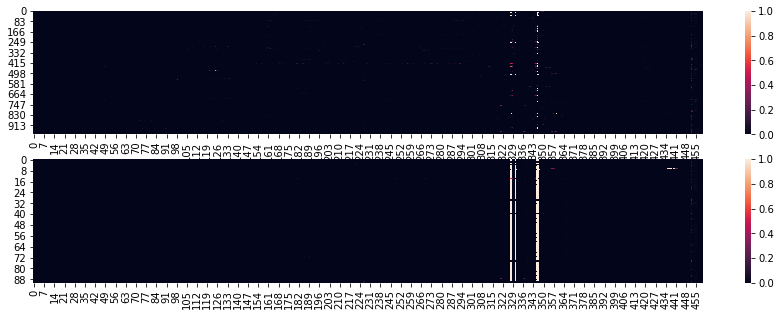

In [ ]:
# Heatmap of the losses
fig, axes = plt.subplots(2, figsize=(15, 5))

normal_loss = calculate_loss(x_validation_normal)
anomalous_loss = calculate_loss(x_validation_anomaly)

sns.heatmap(normal_loss, ax=axes[0])
sns.heatmap(anomalous_loss, ax=axes[1])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


number of chosen col: 22


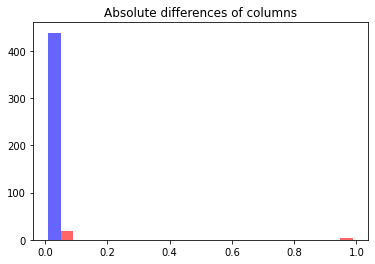

In [ ]:
# Filter the columns according to loss absolute difference
loss_temp = calculate_loss(x_validation)
filter_cond = get_filter_cond(loss_temp[labels_validation==0], loss_temp[labels_validation==1], LOSS_FILTER_COUNT, mode="abs")

loss_filt = filter_columns_of_data(loss_temp, filter_cond)
loss_by_timestamp = np.mean(loss_filt, axis=1)

print("number of chosen col:", loss_filt.shape[1])

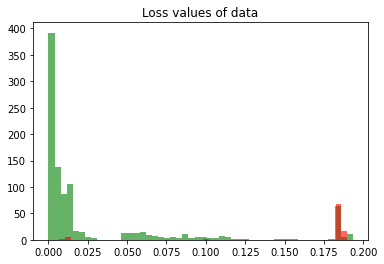

In [ ]:
plt.title("Loss values of data")
plt.hist(loss_by_timestamp[labels_validation==0], alpha=.6, color="green", bins=50)
_ = plt.hist(loss_by_timestamp[labels_validation==1], alpha=.6, color="red", bins=50)  

In [ ]:
# Find threshold
threshold = find_threshold_for_losses(loss_by_timestamp, labels_validation, labels_validation_lag)
print("threshold:" ,threshold)

### Evaluation of the Final Model

Accuracy = 0.961352657004831
Precision = 0.4918918918918919
Recall = 0.900990099009901
F0.5 Score = 0.5410225921521997
F1 Score = 0.6363636363636364
F2 Score = 0.7724957555178268
Confusion Matrix
[[2496   94]
 [  10   91]]


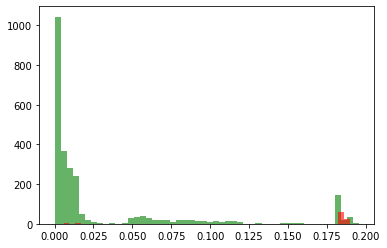

In [ ]:
loss_temp = calculate_loss(x_test)
loss_filt = filter_columns_of_data(loss_temp, filter_cond)
loss_by_timestamp = np.mean(loss_filt, axis=1)

plt.hist(loss_by_timestamp[labels_test==0], alpha=.6, color="green", bins=50)
_ = plt.hist(loss_by_timestamp[labels_test==1], alpha=.6, color="red", bins=50)  

is_anomaly = tf.math.greater(loss_by_timestamp, threshold)
_ = print_stats(is_anomaly, labels_test, labels_test_lag)

Accuracy = 0.968480523342254
Precision = 0.3125
Recall = 0.9158415841584159
F0.5 Score = 0.35992217898832685
F1 Score = 0.46599496221662473
F2 Score = 0.6607142857142857
Confusion Matrix
[[12843   407]
 [   17   185]]


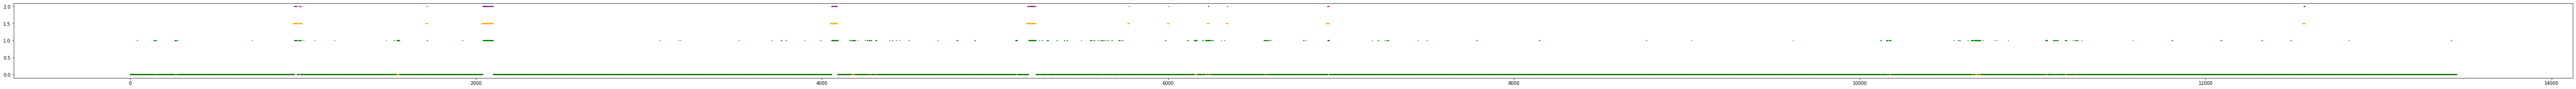

In [ ]:
not_shuffled_label = not_shuffled_data[:, -2]
not_shuffled_label_lag = not_shuffled_data[:, -1]
not_shuffled_timestamps = not_shuffled_data[:, 1:-2]

loss_temp = calculate_loss(not_shuffled_timestamps)
loss_filt = filter_columns_of_data(loss_temp, filter_cond)
loss_by_timestamp = np.mean(loss_filt, axis=1)

is_anomaly = tf.math.greater(loss_by_timestamp, threshold)
print_stats(is_anomaly, not_shuffled_label, not_shuffled_label_lag)
plot_timeline(is_anomaly, not_shuffled_label, not_shuffled_label_lag)

In [ ]:
index_of_columns = np.where(filter_cond)[0]
print(df.columns[index_of_columns])

Index(['var:dimm0_temp', 'var:dimm4_temp', 'var:dimm5_temp', 'var:dimm6_temp',
       'var:dimm7_temp', 'max:p0_core12_temp', 'max:p0_mem_power',
       'min:p0_power', 'max:p1_mem_power', 'min:p1_power',
       'avg:ps0_output_volta', 'var:ps0_output_volta', 'min:ps0_output_volta',
       'var:ps1_output_volta', 'max:ps1_output_volta', 'min:ps1_output_volta',
       'max:total_power', 'avg:proc_total', 'max:proc_total', 'min:proc_total',
       'avg:swap_free', 'max:swap_free'],
      dtype='object')


## Optimization

### All Code

In [ ]:
def autoencoder_run_all(params):
  LATENT_DIM = int(params['latent_dim'])
  HIDDEN_LAYER_COUNT = int(params['hidden_layer_count'])
  NODE_NAME = params['node_name']
  DO_NOT_POSTPROCESS = params.get('do_not_postprocess')

  SEED = params.get('seed') or 42
  os.environ['PYTHONHASHSEED']=str(SEED)
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  sklearn.utils.check_random_state(SEED)
  random.seed(SEED)  

  '''DATA FETCH'''
  # Filter data not between time intervals
  def filter_df_by_time(df, start_date, end_date):
    return df[df["timestamp"].between(pd.Timestamp(start_date), 
                                    pd.Timestamp(end_date))]
  # Read all data
  base_path = "/content/drive/MyDrive/CMPE/Bologna-Internship/new_data/"
  fname = NODE_NAME

  df = pd.read_parquet(base_path+fname)
  df = filter_df_by_time(df, '2020-06-01', '2021-04-01')
  df = df.drop(['timestamp', "label"], axis=1)


  '''PRE-PROCESSING'''
  # Normalize the data to [0,1]
  raw_data = df.to_numpy()
  min_max_scaler = MinMaxScaler() # scale the matrix
  scaled_data = min_max_scaler.fit_transform(raw_data)

  # Add Human Error Lag to Labels for calculating true-positive and false-positive
  def add_lag_to_labels(data, hour=None):
    labels = data[:, -1]

    min = hour*60
    size = int(min/15)
    labels_lag = np.array(labels, copy=True)
    for i, label in enumerate(labels_lag):
      if label == 1 and i > 7 and labels_lag[i-1] != 1:
        labels_lag[i-size:i] = 1

    ids = np.array(range(0, len(labels_lag))).reshape(data.shape[0]) # add id column to dataframe
    labels_lag = labels_lag.reshape(data.shape[0], -1)

    data = np.append(data, labels_lag, axis=1)
    data = np.insert(data, 0, ids, axis=1)

    return data

  # Shuffle data in a way that all anomalies will be inserted to validation and test dataset
  def shuffle_data(data, validation_ratio=0.1, test_ratio=0.2):
    new_data = np.array(data, copy=True)
    np.random.shuffle(new_data) 

    labels_lag = new_data[:, -1] # get labels with lag

    # Split data as normal and anomaly
    normal_data = new_data[labels_lag == 0] 
    anomaly_data = new_data[labels_lag == 1]

    # Collect the anomalies and split to test and validation
    anomaly_end_index = int(anomaly_data.shape[0] * 0.5) # half anomaly to test, half anomaly to validation  
    test_anomaly = anomaly_data[:anomaly_end_index] 
    validation_anomaly = anomaly_data[anomaly_end_index:]
    
    # Insert anomalies to test and validation dataset
    train_end_index = int(new_data.shape[0]*(1-test_ratio-((1-test_ratio)*validation_ratio)))
    validation_end_index = int(new_data.shape[0]*(1-test_ratio))

    result_data = np.insert(normal_data, train_end_index, validation_anomaly, axis=0) # insert anomaly of validation
    result_data = np.insert(result_data, validation_end_index, test_anomaly, axis=0) # insert anomaly of test

    return result_data

  not_shuffled_data = add_lag_to_labels(scaled_data, hour=2)
  data = shuffle_data(not_shuffled_data, validation_ratio=0.1, test_ratio=0.2)

  # Get labels of the data from columns
  labels = data[:, -2]
  labels_lag = data[:, -1]

  # Split the data to train, test, split
  data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)
  data_train, data_validation = train_test_split(data_train, test_size=0.1, shuffle=False)

  x_train = data_train[:, 1:-2]
  x_test = data_test[:, 1:-2]
  x_validation = data_validation[:, 1:-2]

  labels_train = data_train[:, -2]
  labels_test, labels_test_lag = data_test[:, -2], data_test[:, -1]
  labels_validation, labels_validation_lag = data_validation[:, -2], data_validation[:, -1]

  # Split the data to normal, anomaly
  x_train_normal = x_train[labels_train == 0]

  x_test_normal = x_test[labels_test == 0]
  x_validation_normal = x_validation[labels_validation == 0]

  x_test_anomaly = x_test[labels_test == 1]
  x_validation_anomaly = x_validation[labels_validation == 1]



  '''IMPLEMENTATION AND TRAINING'''
  # Functional API implementation of Autoencoder
  input_shape = x_train_normal.shape[1]
  hidden_dims = []

  latent_dim = 40
  n = 3

  decrease_rate = round(np.power((input_shape/latent_dim), 1/(n+1)), 3)

  for i in range(0, n):
    if i == 0:
      hidden_dims.append(int(input_shape / decrease_rate))
    else:
      hidden_dims.append(int(hidden_dims[i-1] / decrease_rate))

  latent_dim = int(np.ceil(hidden_dims[-1] / decrease_rate))

  # Encoder
  encoder_input = tf.keras.Input(shape=input_shape, name="original_data")
  x = tf.keras.layers.Dense(hidden_dims[0], activation="relu")(encoder_input)
  for i in range(1,n):
    x = tf.keras.layers.Dense(hidden_dims[i], activation="relu")(x)
  encoder_output = tf.keras.layers.Dense(latent_dim, activation="relu")(x)

  encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")

  # Decoder
  decoder_input = tf.keras.Input(shape=latent_dim, name="encoded_data")
  x = tf.keras.layers.Dense(hidden_dims[-1], activation="relu")(decoder_input)
  for i in range(2, n+1):
    x = tf.keras.layers.Dense(hidden_dims[-i], activation="relu")(x)
  decoder_output = tf.keras.layers.Dense(input_shape, activation="sigmoid")(x)

  decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")

  # Autoencoder
  autoencoder_input = tf.keras.Input(shape=input_shape, name="data")
  encoded_data = encoder(autoencoder_input)
  decoded_data = decoder(encoded_data)
  autoencoder = tf.keras.Model(autoencoder_input, decoded_data, name="autoencoder")

  autoencoder.compile(optimizer='adam', loss='mae')
  history = autoencoder.fit(x_train_normal, x_train_normal, 
            epochs=100, 
            batch_size=512,
            validation_data=(x_validation_normal, x_validation_normal),
            shuffle=False,
            verbose=0)


  if DO_NOT_POSTPROCESS:
    return encoder, x_validation, labels_validation, x_test, labels_test, labels_test_lag, not_shuffled_data, data, data_train, data_validation, data_test



  '''EVALUATION'''
  def evaluation_metrics(pred, labels, labels_lag):
    tn, _, fn, _ = confusion_matrix(labels, pred).ravel()
    _, fp, _, tp = confusion_matrix(labels_lag, pred).ravel()

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f0dot5 = (1.25 * precision * recall) / (0.25 * precision + recall)
    f1 = (2 * precision * recall) / (precision + recall)
    f2 = (5 * precision * recall) / (4 * precision + recall)

    return accuracy, precision, recall, np.array([[tn, fp], [fn, tp]]), f0dot5, f1 ,f2

  def find_threshold_for_losses(losses, labels, labels_lag):
    max_threshold = -1
    max_score = -1
    step = np.mean(losses) / 100
    float_range_list = list(np.arange(0, np.max(losses), step))

    for threshold in float_range_list:
      pred = losses > threshold
      accuracy, precision, recall, *_, f2 = evaluation_metrics(pred, labels==1, labels_lag==1)

      tmp_score = f2
      if tmp_score > max_score:
        max_threshold = threshold
        max_score = tmp_score
    
    return max_threshold

  custom_loss_func = tf.keras.losses.mse
  reconstructions = autoencoder.predict(x_validation)
  loss_by_timestamp = custom_loss_func(reconstructions, x_validation)

  threshold = find_threshold_for_losses(loss_by_timestamp, labels_validation, labels_validation_lag)
  
  def predict(model, data, threshold, loss_func):
    reconstructions = model(data)
    loss = loss_func(reconstructions, data)
    return tf.math.greater(loss, threshold)

  preds = predict(autoencoder, x_test, threshold, custom_loss_func)
  test_accuracy, test_precision, test_recall, test_conf_matrix, test_f0dot5, test_f1, test_f2 = evaluation_metrics(preds, labels_test==1, labels_test_lag==1)

  not_shuffled_label = not_shuffled_data[:, -2]
  not_shuffled_label_lag = not_shuffled_data[:, -1]
  not_shuffled_timestamps = not_shuffled_data[:, 1:-2]

  is_anomaly = predict(autoencoder, not_shuffled_timestamps, threshold, custom_loss_func)
  all_accuracy, all_precision, all_recall, all_conf_matrix, all_f0dot5, all_f1, all_f2 = evaluation_metrics(is_anomaly, not_shuffled_label==1, not_shuffled_label_lag==1)

  '''POST-PROCESSING'''
  LOSS_FILTER_COUNT = int(params['loss_filter_count'])

  def filter_columns_of_data(data, filter_cond, axis=1):
    cond_expand = (np.zeros(shape=data.shape) + filter_cond).astype(bool)
    data_filt = data[cond_expand].reshape(data.shape[0], -1)

    return data_filt
  def avt_filter(data):
    result = []
    for i, col in enumerate(data.transpose()):
      col = col[col <= col.mean()+col.std()]
      col = col[col.mean()-col.std() <= col]

      result.append(col.mean())

    return np.array(result)
  # Filter the columns with high importance to loss
  def get_filter_cond(data1, data2, count, mode="normal"):
    data1_feature_mean = avt_filter(data1)
    data2_feature_mean = avt_filter(data2)

    abs_diff = data1_feature_mean - data2_feature_mean
    if mode == "abs":
      abs_diff = np.abs(abs_diff)

    abs_diff_indexes = enumerate(abs_diff) # find the ones with high differences
    cond_indexes = np.array(sorted(abs_diff_indexes, key=lambda x: x[1]), dtype="int64")[-count:, 0]

    cond = np.zeros(data1.shape[1]).astype(bool)
    np.put(cond, cond_indexes, [True])

    return cond

  def calculate_loss(data):
    reconstructions = autoencoder.predict(data)
    loss = np.square(np.abs(data - reconstructions))
    return loss

  # Filter the columns according to loss absolute difference
  loss_temp = calculate_loss(x_validation)
  filter_cond = get_filter_cond(loss_temp[labels_validation==0], loss_temp[labels_validation==1], LOSS_FILTER_COUNT, mode="abs")

  loss_filt = filter_columns_of_data(loss_temp, filter_cond)
  loss_by_timestamp = np.mean(loss_filt, axis=1)

  # Find threshold
  threshold = find_threshold_for_losses(loss_by_timestamp, labels_validation, labels_validation_lag)

  # Evaluation of the Final Model
  loss_temp = calculate_loss(x_test)
  loss_filt = filter_columns_of_data(loss_temp, filter_cond)
  loss_by_timestamp = np.mean(loss_filt, axis=1)

  is_anomaly = tf.math.greater(loss_by_timestamp, threshold)
  test_accuracy_post, test_precision_post, test_recall_post, test_conf_matrix_post, test_f0dot5_post, test_f1_post, test_f2_post = evaluation_metrics(is_anomaly, labels_test==1, labels_test_lag==1)

  loss_temp = calculate_loss(not_shuffled_timestamps)
  loss_filt = filter_columns_of_data(loss_temp, filter_cond)
  loss_by_timestamp = np.mean(loss_filt, axis=1)

  is_anomaly = tf.math.greater(loss_by_timestamp, threshold)
  all_accuracy_post, all_precision_post, all_recall_post, all_conf_matrix_post, all_f0dot5_post, all_f1_post, all_f2_post = evaluation_metrics(is_anomaly, not_shuffled_label==1, not_shuffled_label_lag==1)


  '''Record the results'''
  result = []
  result.append(len(hidden_dims))
  result.append(round(decrease_rate, 3))
  result.append(SEED)
  result.append(LOSS_FILTER_COUNT)
  result.append(NODE_NAME)
  result.append(hidden_dims)
  result.append(latent_dim)
  result.append(round(test_accuracy, 2))
  result.append(round(test_precision, 2))
  result.append(round(test_recall, 2))
  result.append(round(test_f0dot5, 2))
  result.append(round(test_f1, 2))
  result.append(round(test_f2, 2))
  result.append(test_conf_matrix)
  result.append(round(all_accuracy, 2))
  result.append(round(all_precision, 2))
  result.append(round(all_recall, 2))
  result.append(round(all_f0dot5, 2))
  result.append(round(all_f1, 2))
  result.append(round(all_f2, 2))
  result.append(all_conf_matrix)
  result.append(round(test_accuracy_post, 2))
  result.append(round(test_precision_post, 2))
  result.append(round(test_recall_post, 2))
  result.append(round(test_f0dot5_post, 2))
  result.append(round(test_f1_post, 2))
  result.append(round(test_f2_post, 2))
  result.append(test_conf_matrix_post)
  result.append(round(all_accuracy_post, 2))
  result.append(round(all_precision_post, 2))
  result.append(round(all_recall_post, 2))
  result.append(round(all_f0dot5_post, 2))
  result.append(round(all_f1_post, 2))
  result.append(round(all_f2_post, 2))
  result.append(all_conf_matrix_post)

  df_result = None
  columns = ["Number of Hidden Dims", "Decrease Rate of Layers' Units",  "Seed", "Loss Filter Count", "Node Name", "Hidden Dims", "Latent Dim", 
             "Test Accuracy", "Test Precision", 
             "Test Recall", "Test F0.5-Score","Test F1-Score","Test F2-Score", "Test Conf. Matrix", "All Data Accuracy", "All Data Precision", "All Data Recall", "All Data F0.5-Score","All Data F1-Score","All Data F2-Score" ,
             "All Data Conf. Matrix", 
             "Post_Test Accuracy", "Post_Test Precision", 
             "Post_Test Recall", "Post_Test F0.5-Score","Post_Test F1-Score","Post_Test F2-Score", "Post_Test Conf. Matrix", "Post All Data Accuracy", "Post All Data Precision", "Post All Data Recall", "Post All Data F0.5-Score","Post All Data F1-Score","Post All Data F2-Score",
             "Post All Data Conf. Matrix",
             ]
  try:
    df_result = pd.read_csv("results.csv", index_col=False)
  except:
    df_result = pd.DataFrame([], columns=columns)

  df_result.to_csv("temp_results.csv", index=False)
  df_result = df_result.append(dict(zip(columns, result)), ignore_index=True)
  df_result.to_csv("results.csv", index=False)
  df_result

  return {'loss': -all_f2_post, 'status': STATUS_OK}

### Bayesian

In [ ]:
space = {
    'latent_dim': hp.quniform('latent_dim', 40, 300, 1),
    'hidden_layer_count': hp.quniform('hidden_layer_count', 1, 10, 1),
    'loss_filter_count': hp.quniform('loss_filter_count', 20, 80, 1),
    'node_name': hp.choice('node_name', ['r207n02.gzip']),
}
algo = tpe.suggest
trials = Trials()

In [ ]:
best = fmin(fn=autoencoder_run_all, space=space, algo=algo, trials=trials, max_evals=1)
pickle.dump(trials, open("autoencoder-bayesian.p", "wb"))

In [ ]:
df_bayesian = pd.DataFrame({
    'loss': [x['loss'] for x in trials.results], 
    'iteration': trials.idxs_vals[0]['latent_dim'], 
    'latent_dim': trials.idxs_vals[1]['latent_dim'],
    'hidden_layer_count': trials.idxs_vals[1]['hidden_layer_count'],
    'loss_filter_count': trials.idxs_vals[1]['loss_filter_count'],
    'node_name': trials.idxs_vals[1]['node_name'],    
    })

df_bayesian = df_bayesian.sort_values(['loss'])
df_bayesian

,loss,iteration,latent_dim,hidden_layer_count,loss_filter_count,node_name
0,-0.53469,0,71.0,7.0,66.0,0


# Classification Network using Latent Dimension

## Pre-processing

In [ ]:
autoencoder_params = {
    'latent_dim': 40,
    'hidden_layer_count': 3,
    'node_name': 'r207n02.gzip',
    'do_not_postprocess': True
}
encoder, x_validation, labels_validation, x_test, labels_test, labels_test_lag, not_shuffled_data, data, data_train, data_validation, data_test = autoencoder_run_all(autoencoder_params)

In [ ]:
# Calculate Train Set
xx_train = encoder(x_validation).numpy()
yy_train = labels_validation

anomaly_ratio = x_validation[labels_validation==1].shape[0] / (x_validation[labels_validation==1].shape[0]+x_validation[labels_validation==0].shape[0])
sampling_rate = None
if anomaly_ratio < 0.07:
  sampling_rate = 0.25
elif anomaly_ratio < 0.5:
  sampling_rate = 0.5
else:
  sampling_rate = 1.

# Resample
xx_train, yy_train = SVMSMOTE(sampling_strategy=sampling_rate).fit_resample(xx_train, yy_train)

# Calculate Test Set
xx_test = encoder(x_test).numpy()
yy_test = labels_test

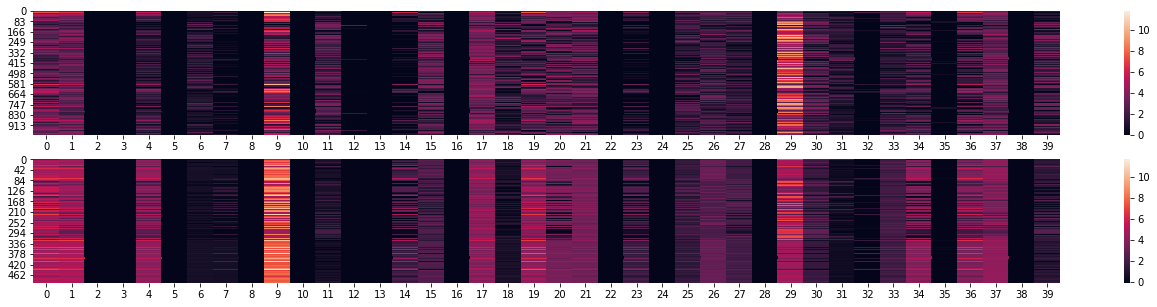

In [ ]:
fig, axes = plt.subplots(2, figsize=(23, 5))

sns.heatmap(xx_train[yy_train==0], ax=axes[0])
sns.heatmap(xx_train[yy_train==1], ax=axes[1])

## Implementation and Training

In [ ]:
decrease_rate = 1.4
n = 5
start_dim = 55

# Functional API implementation of Classifier
classifier_input_shape = xx_train.shape[1]
hidden_dims = []

for i in range(0, n):
  if i == 0:
    hidden_dims.append(start_dim)
  else:
    hidden_dims.append(int(hidden_dims[i-1] / decrease_rate))

hidden_dims = [x if x != 0 else 1 for x in hidden_dims] # if there is hidden_dims=0 make it 1 

input = tf.keras.Input(shape=classifier_input_shape, name="latent_dimension")
x = tf.keras.layers.Dense(hidden_dims[0], activation="relu")(input)
for i in range(1, n):
  x = tf.keras.layers.Dense(hidden_dims[i], activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

classifier = tf.keras.Model(input, output, name="classifier")
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_dimension (InputLayer [(None, 40)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 55)                2255      
_________________________________________________________________
dense_21 (Dense)             (None, 39)                2184      
_________________________________________________________________
dense_22 (Dense)             (None, 27)                1080      
_________________________________________________________________
dense_23 (Dense)             (None, 19)                532       
_________________________________________________________________
dense_24 (Dense)             (None, 13)                260       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 1

In [ ]:
classifier.compile(optimizer="adam", loss='binary_crossentropy', metrics="accuracy")

In [ ]:
history = classifier.fit(xx_train, yy_train, 
          epochs=1000, 
          batch_size=64,
          shuffle=True)

## Evaluation

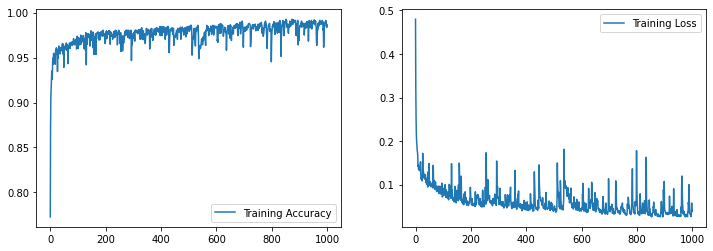

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(history.history["accuracy"], label="Training Accuracy")
axs[0].legend()

axs[1].plot(history.history["loss"], label="Training Loss")
axs[1].legend()

In [ ]:
def classifier_evaluate(data, labels, labels_lag):
  predictions = [round(x[0]) for x in classifier.predict(data)]

  tn, _, fn, _ = confusion_matrix(labels==1, predictions).ravel()
  _, fp, _, tp = confusion_matrix(labels_lag==1, predictions).ravel()
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f0dot5 = (1.25 * precision * recall) / (0.25 * precision + recall)
  f1 = (2 * precision * recall) / (precision + recall)
  f2 = (5 * precision * recall) / (4 * precision + recall)
  conf_matrix = np.array([[tn, fp], [fn, tp]])

  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F0.5 Score:", f0dot5)
  print("F1 Score:", f1)
  print("F2 Score:", f2)  
  print(conf_matrix)

  return predictions, accuracy, precision, recall, conf_matrix, f0dot5, f1 ,f2

In [ ]:
def plot_timeline(predictions, labels, labels_lag):
  ids = np.array(data[:, 0], dtype="int64") # first column is the id of the timestamp
  ids_train = np.array(data_train[:, 0], dtype="int64")
  ids_test = np.array(data_test[:, 0], dtype="int64")
  ids_validation = np.array(data_validation[:, 0], dtype="int64")  

  color = np.zeros(shape=ids.shape).astype(str)
  np.put(color, ids_validation, "blue")
  np.put(color, ids_test, "red")
  np.put(color, ids_train, "green")
  time = range(0,len(labels))

  plt.figure(figsize=(100,3))
  plt.scatter(time, labels*2, c=color, s=1)
  plt.scatter(time, labels_lag*1.5, c="orange", s=1)
  plt.scatter(time, predictions, c='g', s=1)

In [ ]:
print("CLASSIFIER TRAIN")
_ = classifier_evaluate(xx_train, yy_train, yy_train)

CLASSIFIER TRAIN
Accuracy: 0.9871534820824882
Recall: 1.0
Precision: 0.962890625
F0.5 Score: 0.970090515545061
F1 Score: 0.981094527363184
F2 Score: 0.9923510466988728
[[967  19]
 [  0 493]]


In [ ]:
print("CLASSIFIER TEST")
_ = classifier_evaluate(xx_test, yy_test, labels_test_lag)

CLASSIFIER TEST
Accuracy: 0.9765886287625418
Recall: 0.9047619047619048
Precision: 0.6418918918918919
F0.5 Score: 0.6814921090387375
F1 Score: 0.75098814229249
F2 Score: 0.8362676056338029
[[2533   53]
 [  10   95]]


Accuracy: 0.9821587867975022
Recall: 0.9427083333333334
Precision: 0.44146341463414634
F0.5 Score: 0.4939956331877729
F1 Score: 0.601328903654485
F2 Score: 0.768251273344652
[[13031   229]
 [   11   181]]


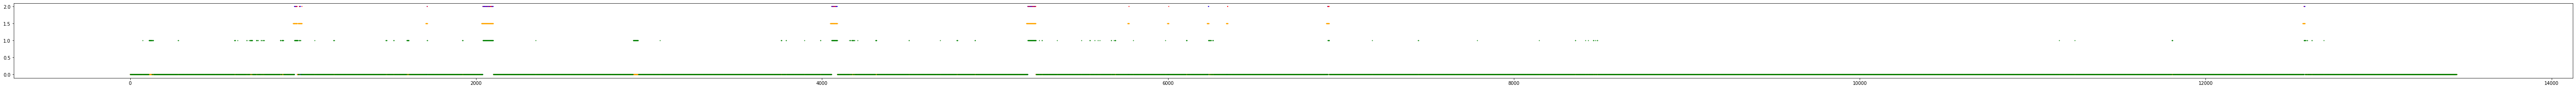

In [ ]:
not_shuffled_label = not_shuffled_data[:, -2]
not_shuffled_label_lag = not_shuffled_data[:, -1]
not_shuffled_timestamps = not_shuffled_data[:, 1:-2]

predictions, *_ = classifier_evaluate(encoder(not_shuffled_timestamps).numpy(), not_shuffled_label, not_shuffled_label_lag)
plot_timeline(predictions, not_shuffled_label, not_shuffled_label_lag)

## Optimization

### All Code

In [ ]:
def classifier_run_all(params):
  start_dim = int(params['start_dim'])
  decrease_rate = params['decrease_rate']
  n = int(params['hidden_layer_count'])
  node_name = params['node_name']


  epoch_count = 1000

  seed = 42  
  os.environ['PYTHONHASHSEED']=str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  sklearn.utils.check_random_state(seed)
  random.seed(seed)  

  # Train Autoencoder
  autoencoder_params = {
      'latent_dim': 40,
      'hidden_layer_count': 3,
      'node_name': node_name,
      'seed': seed,
      'do_not_postprocess': True
  }
  encoder, x_validation, labels_validation, x_test, labels_test, labels_test_lag, not_shuffled_data, data, data_train, data_validation, data_test = autoencoder_run_all(autoencoder_params)
 
  # Calculate Train Set
  xx_train = encoder(x_validation).numpy()
  yy_train = labels_validation

  anomaly_ratio = x_validation[labels_validation==1].shape[0] / (x_validation[labels_validation==1].shape[0]+x_validation[labels_validation==0].shape[0])
  sampling_rate = None
  if anomaly_ratio < 0.07:
    sampling_rate = 0.25
  elif anomaly_ratio < 0.5:
    sampling_rate = 0.5
  else:
    sampling_rate = 1.

  # Resample
  xx_train, yy_train = SVMSMOTE(sampling_strategy=sampling_rate).fit_resample(xx_train, yy_train)

  # Calculate Test Set
  xx_test = encoder(x_test).numpy()
  yy_test = labels_test



  # Functional API implementation of Classifier
  classifier_input_shape = xx_train.shape[1]
  hidden_dims = []

  for i in range(0, n):
    if i == 0:
      hidden_dims.append(start_dim)
    else:
      hidden_dims.append(int(hidden_dims[i-1] / decrease_rate))

  hidden_dims = [x if x != 0 else 1 for x in hidden_dims] # if there is hidden_dims=0 make it 1 

  input = tf.keras.Input(shape=classifier_input_shape, name="data")
  x = tf.keras.layers.Dense(hidden_dims[0], activation="relu")(input)
  for i in range(1, n):
    x = tf.keras.layers.Dense(hidden_dims[i], activation="relu")(x)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  classifier = tf.keras.Model(input, output, name="classifier")
  classifier.compile(optimizer="adam", loss='binary_crossentropy', metrics="accuracy")

  history = classifier.fit(xx_train, yy_train, 
        epochs=epoch_count, 
        batch_size=64,
        shuffle=True,
        verbose=0,
    )

  def evaluation_metrics(pred, labels, labels_lag):
    tn, _, fn, _ = confusion_matrix(labels, pred).ravel()
    _, fp, _, tp = confusion_matrix(labels_lag, pred).ravel()

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f0dot5 = (1.25 * precision * recall) / (0.25 * precision + recall)
    f1 = (2 * precision * recall) / (precision + recall)
    f2 = (5 * precision * recall) / (4 * precision + recall)

    return accuracy, precision, recall, np.array([[tn, fp], [fn, tp]]), f0dot5, f1 ,f2

  predictions = [round(x[0]) for x in classifier.predict(encoder(x_test).numpy())]
  test_accuracy, test_precision, test_recall, test_conf_matrix, test_f0dot5, test_f1, test_f2 = evaluation_metrics(predictions, labels_test==1, labels_test_lag==1)

  not_shuffled_label = not_shuffled_data[:, -2]
  not_shuffled_label_lag = not_shuffled_data[:, -1]
  not_shuffled_timestamps = not_shuffled_data[:, 1:-2]

  predictions = [round(x[0]) for x in classifier.predict(encoder(not_shuffled_timestamps).numpy())]
  all_accuracy, all_precision, all_recall, all_conf_matrix, all_f0dot5, all_f1, all_f2 = evaluation_metrics(predictions, not_shuffled_label, not_shuffled_label_lag)


  if np.isnan(all_f2):
    all_f2 = 0

  print(params, all_conf_matrix, all_f2)

  result = []
  result.append(node_name)
  result.append(seed)
  result.append(round(test_accuracy, 2))
  result.append(round(test_precision, 2))
  result.append(round(test_recall, 2))
  result.append(round(test_f0dot5, 2))
  result.append(round(test_f1, 2))
  result.append(round(test_f2, 2))
  result.append(test_conf_matrix)
  result.append(round(all_accuracy, 2))
  result.append(round(all_precision, 2))
  result.append(round(all_recall, 2))
  result.append(round(all_f0dot5, 2))
  result.append(round(all_f1, 2))
  result.append(round(all_f2, 2))
  result.append(all_conf_matrix)

  df_result = None
  columns = ["Node Name", "Seed",
             "Test Accuracy", "Test Precision", "Test Recall", "Test F0.5-Score","Test F1-Score","Test F2-Score", "Test Conf. Matrix",
             "All Accuracy", "All Precision", "All Recall", "All F0.5-Score","All F1-Score","All F2-Score", "All Conf. Matrix"]  
  try:
    df_result = pd.read_csv("results.csv", index_col=False)
  except:
    df_result = pd.DataFrame([], columns=columns)

  df_result.to_csv("temp_results.csv", index=False)
  df_result = df_result.append(dict(zip(columns, result)), ignore_index=True)
  df_result.to_csv("results.csv", index=False)

  return {'loss': -all_f2, 'status': STATUS_OK} 

### Bayesian

In [ ]:
space = {
    'decrease_rate': hp.uniform('decrease_rate', 1, 2),
    'hidden_layer_count': hp.quniform('hidden_layer_count', 1, 10, 1),
    'start_dim': hp.quniform('start_dim', 40, 70, 1),
    'node_name': hp.choice('node_name', ['r207n02.gzip']),
}
algo = tpe.suggest
trials = Trials()

In [ ]:
best = fmin(fn=classifier_run_all, space=space, algo=algo, trials=trials, max_evals=1)
pickle.dump(trials, open("classifier-bayesian.p", "wb"))

In [ ]:
df = pd.DataFrame({
    'loss': [x['loss'] for x in trials.results], 
    'iteration': trials.idxs_vals[0]['decrease_rate'], 
    'decrease_rate': trials.idxs_vals[1]['decrease_rate'],
    'hidden_layer_count': trials.idxs_vals[1]['hidden_layer_count'],
    'start_dim': trials.idxs_vals[1]['start_dim'],
    })

df = df.sort_values(['loss'])
df

,loss,iteration,decrease_rate,hidden_layer_count,start_dim
0,-0.759745,0,1.828047,3.0,47.0
